# 🏀 NBA Predictor — Colab Setup

This notebook sets up the upgraded NBA match-winner prediction project in **Google Colab + Drive**.

**What it does:**
1. Mounts Drive and picks a project folder.
2. Clones your GitHub repo **or** creates a fresh project skeleton.
3. Writes the upgraded `src/plus/` feature/ratings/calibration code.
4. Creates `data/team_coords.csv` for travel/rest features.
5. Installs dependencies.
6. (Optional) Pulls **pregame odds** from The Odds API.
7. Trains with **walk-forward time-aware CV** and **calibrated probabilities**.

> You can re-run this notebook anytime; it will overwrite files safely.

## 1) Mount Google Drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) Choose where to put the project & (optionally) your GitHub repo

In [34]:
import os, getpass

# Change the folder name if you want:
PROJECT_DIR = "/content/drive/MyDrive/nba-prediction"
# REPO_URL = "https://github.com/kevinxu23/nba-prediction.git"  # set "" to skip cloning and just create skeleton
REPO_URL = ""  # set "" to skip cloning and just create skeleton
# If your repo is PRIVATE, set this True to be prompted for a token.
IS_PRIVATE = False

os.makedirs(PROJECT_DIR, exist_ok=True)
%cd "$PROJECT_DIR"

if REPO_URL:
    if IS_PRIVATE:
        token = getpass.getpass("GitHub Personal Access Token (not shown): ").strip()
        os.environ["GITHUB_TOKEN"] = token
        !git clone https://$GITHUB_TOKEN@{REPO_URL.split('https://github.com/')[-1]} . || true
    else:
        !git clone {REPO_URL} . || true

print("Working in:", os.getcwd())

/content/drive/MyDrive/nba-prediction
Working in: /content/drive/MyDrive/nba-prediction


### (Optional) If your repo uses Git LFS, enable it

In [ ]:
# Run only if your repo uses Git LFS (safe to run anyway).
!sudo apt-get update -y >/dev/null 2>&1
!sudo apt-get install -y git-lfs >/dev/null 2>&1
!git lfs install
# If you skipped LFS during clone, you can selectively pull later:
# !git lfs pull --include="data/**,models/**"

Git LFS initialized.


## 3) Create/ensure the project skeleton exists

In [35]:
import os, pathlib
for p in ["src/plus", "scripts", "models", "data"]:
    os.makedirs(p, exist_ok=True)
# make sure src is a package
pathlib.Path("src/__init__.py").touch()
print("Project tree ready.")
!ls -la

Project tree ready.
total 453
drwx------ 4 root root   4096 Sep 14 03:55 data
-rw------- 1 root root     64 Sep 13 17:54 kaggle.json
drwx------ 2 root root   4096 Sep 14 04:01 models
-rw------- 1 root root 283198 Sep 14 04:52 NBA_EDA.ipynb
-rw------- 1 root root 162017 Sep 14 05:06 NBA_Predictor_Colab2.ipynb
-rw------- 1 root root    139 Sep 14 03:49 requirements.plus.txt
drwx------ 3 root root   4096 Sep 14 03:56 scripts
drwx------ 4 root root   4096 Sep 12 22:12 src


## 4) Create `data/team_coords.csv` (arenas + coords)

In [36]:
%%writefile data/team_coords.csv
TEAM_ABBREV,arena_name,arena_lat,arena_lon,altitude_m
ATL,State Farm Arena,33.7573,-84.3963,
BOS,TD Garden,42.3663,-71.0622,
BKN,Barclays Center,40.6827,-73.9757,
CHA,Spectrum Center,35.2251,-80.8392,
CHI,United Center,41.8807,-87.6742,
CLE,Rocket Mortgage FieldHouse,41.4965,-81.6882,
DAL,American Airlines Center,32.7905,-96.8104,
DEN,Ball Arena,39.7487,-105.0077,1608
DET,Little Caesars Arena,42.3410,-83.0553,
GSW,Chase Center,37.7680,-122.3877,
HOU,Toyota Center,29.7508,-95.3621,
IND,Gainbridge Fieldhouse,39.7640,-86.1555,
LAC,Intuit Dome,33.9438,-118.3426,
LAL,Crypto.com Arena,34.0430,-118.2673,
MEM,FedExForum,35.1382,-90.0506,
MIA,Kaseya Center,25.7814,-80.1870,
MIL,Fiserv Forum,43.0451,-87.9172,
MIN,Target Center,44.9795,-93.2760,
NOP,Smoothie King Center,29.9490,-90.0815,
NYK,Madison Square Garden,40.7505,-73.9934,
OKC,Paycom Center,35.4634,-97.5151,
ORL,Kia Center,28.5393,-81.3839,
PHI,Wells Fargo Center,39.9012,-75.1719,
PHX,Footprint Center,33.4457,-112.0712,
POR,Moda Center,45.5316,-122.6668,
SAC,Golden 1 Center,38.5802,-121.4996,
SAS,Frost Bank Center,29.4269,-98.4375,
TOR,Scotiabank Arena,43.6435,-79.3791,
UTA,Delta Center,40.7683,-111.9011,1288
WAS,Capital One Arena,38.8981,-77.0209,

Overwriting data/team_coords.csv


## 5) Dependencies

In [ ]:
%%writefile requirements.plus.txt
lightgbm>=4.3
xgboost>=2.0
catboost>=1.2
mapie>=0.6
matplotlib>=3.8
seaborn>=0.13
scikit-learn>=1.6
numpy>=1.26
pandas>=2.2
requests>=2.31

Overwriting requirements.plus.txt


In [ ]:
# Also install base requirements if your repo has them
!pip install -q -r requirements.plus.txt
if os.path.exists("requirements.txt"):
    !pip install -q -r requirements.txt || true

import sys, os
sys.path.append(os.getcwd())
print("Python path set.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 kB 14.4 MB/s eta 0:00:00
Python path set.


## 6) Add the upgraded code files (`src/plus` & `scripts`)

In [ ]:
%%writefile src/plus/utils.py
from __future__ import annotations
import math
import pandas as pd
import numpy as np

EARTH_R_KM = 6371.0

def haversine_km(lat1, lon1, lat2, lon2) -> float:
    """Great-circle distance via the haversine formula (km)."""
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat/2)**2
         + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return EARTH_R_KM * c

def safe_div(num, den):
    return np.where(den == 0, np.nan, num / den)

def as_date(s: pd.Series|pd.DatetimeIndex) -> pd.Series:
    return pd.to_datetime(s).dt.tz_localize(None)

TEAM_ABBREV_FIX = {
    "LA Clippers": "LAC", "Los Angeles Clippers": "LAC",
    "LA Lakers": "LAL", "Los Angeles Lakers": "LAL",
    "New York Knicks": "NYK", "New Orleans Pelicans": "NOP",
    "Golden State Warriors": "GSW", "Portland Trail Blazers": "POR",
}

def canon_team(name_or_abbrev: str) -> str:
    x = name_or_abbrev.strip()
    return TEAM_ABBREV_FIX.get(x, x)

Overwriting src/plus/utils.py


In [ ]:
%%writefile src/plus/ratings.py
from __future__ import annotations
import numpy as np
import pandas as pd
from dataclasses import dataclass

@dataclass
class EloConfig:
    k_base: float = 20.0
    mov_mult: float = 0.006
    home_court: float = 60.0
    regress_to_mean: float = 0.25
    base: float = 1500.0

class Elo:
    def __init__(self, cfg: EloConfig = EloConfig()):
        self.cfg = cfg
        self.ratings: dict[str, float] = {}

    def _ensure(self, team: str):
        if team not in self.ratings:
            self.ratings[team] = self.cfg.base

    def expected(self, h_elo, a_elo):
        return 1.0 / (1.0 + 10.0 ** ((a_elo - h_elo) / 400.0))

    def update_game(self, home, away, home_pts, away_pts):
        self._ensure(home); self._ensure(away)
        h = self.ratings[home] + self.cfg.home_court
        a = self.ratings[away]
        exp = self.expected(h, a)

        s = 1.0 if home_pts > away_pts else 0.0
        mov = abs(home_pts - away_pts)
        k = self.cfg.k_base * (1 + self.cfg.mov_mult * mov)

        delta = k * (s - exp)
        self.ratings[home] += delta
        self.ratings[away] -= delta

    def preseason_regress(self):
        mean = np.mean(list(self.ratings.values())) if self.ratings else self.cfg.base
        for t in list(self.ratings):
            self.ratings[t] = (1 - self.cfg.regress_to_mean) * self.ratings[t] + self.cfg.regress_to_mean * mean

def compute_daily_elo(games_df: pd.DataFrame,
                      home_col="HOME_TEAM_ABBREV", away_col="AWAY_TEAM_ABBREV",
                      home_pts_col="PTS_home", away_pts_col="PTS_away",
                      date_col="GAME_DATE",
                      cfg: EloConfig = EloConfig()) -> pd.DataFrame:
    df = games_df.copy().sort_values(date_col)
    elo = Elo(cfg)
    rows = []
    cur_season = None
    for _, r in df.iterrows():
        dt = pd.to_datetime(r[date_col])
        season = dt.year if dt.month >= 10 else dt.year - 1
        if cur_season is None:
            cur_season = season
        if season != cur_season:
            elo.preseason_regress()
            cur_season = season

        h, a = str(r[home_col]), str(r[away_col])
        elo._ensure(h); elo._ensure(a)
        h_pre, a_pre = elo.ratings[h] + cfg.home_court, elo.ratings[a]
        rows.append((r["GAME_ID"], h_pre, a_pre, (h_pre - a_pre)))

        if pd.notnull(r.get(home_pts_col)) and pd.notnull(r.get(away_pts_col)):
            elo.update_game(h, a, int(r[home_pts_col]), int(r[away_pts_col]))

    out = pd.DataFrame(rows, columns=["GAME_ID", "elo_home", "elo_away", "elo_diff"])
    return out

def fit_bt_strengths(games_df: pd.DataFrame,
                     home_team_col="HOME_TEAM_ABBREV",
                     away_team_col="AWAY_TEAM_ABBREV",
                     home_win_col="home_team_wins") -> pd.Series:
    import statsmodels.api as sm
    df = games_df[[home_team_col, away_team_col, home_win_col]].dropna().copy()
    teams = sorted(set(df[home_team_col]) | set(df[away_team_col]))
    for t in teams:
        df[f"T_{t}_home"] = (df[home_team_col] == t).astype(int)
        df[f"T_{t}_away"] = (df[away_team_col] == t).astype(int)
    diffs = []
    for t in teams[:-1]:
        diffs.append(df[f"T_{t}_home"] - df[f"T_{t}_away"])
    import numpy as np
    X = np.vstack(diffs).T
    X = sm.add_constant(X)
    y = df[home_win_col].astype(int).values
    model = sm.Logit(y, X).fit(disp=False)
    beta = model.params
    strengths = pd.Series(beta[1:], index=teams[:-1])
    strengths[teams[-1]] = 0.0
    strengths -= strengths.mean()
    strengths.name = "bt_strength"
    strengths.attrs["hca_intercept"] = float(beta[0])
    return strengths

Overwriting src/plus/ratings.py


In [ ]:
%%writefile src/plus/odds_utils.py
from __future__ import annotations
import pandas as pd
import numpy as np

def american_to_prob(odds: float) -> float:
    o = float(odds)
    if o > 0:
        return 100.0 / (o + 100.0)
    else:
        return (-o) / ((-o) + 100.0)

def pair_no_vig_probs(home_odds: float, away_odds: float) -> tuple[float,float]:
    p_h = american_to_prob(home_odds)
    p_a = american_to_prob(away_odds)
    s = p_h + p_a
    if s <= 0:
        return (np.nan, np.nan)
    return (p_h / s, p_a / s)

def consensus_home_prob(odds_rows: list[tuple[float,float]]) -> float:
    fair_ps = [pair_no_vig_probs(h,a)[0] for (h,a) in odds_rows if pd.notnull(h) and pd.notnull(a)]
    if not fair_ps:
        return np.nan
    return float(np.median(fair_ps))

def attach_odds_features(games_df: pd.DataFrame, odds_df: pd.DataFrame,
                         key_cols=("GAME_DATE", "HOME_TEAM_ABBREV", "AWAY_TEAM_ABBREV")) -> pd.DataFrame:
    o = odds_df.copy()
    o["pair"] = list(zip(o["home_ml"], o["away_ml"]))
    agg = (o.groupby(list(key_cols))["pair"]
             .apply(lambda x: consensus_home_prob(list(x)))
             .reset_index()
             .rename(columns={"pair":"fair_home_prob"}))
    return games_df.merge(agg, on=list(key_cols), how="left")

Overwriting src/plus/odds_utils.py


In [ ]:
%%writefile src/plus/features_extra.py
from __future__ import annotations
import pandas as pd
import numpy as np
from .utils import haversine_km  # for travel distance

# ---------- Flexible column resolver ----------
_ALIASES = {
    "FG":  ["FG","FGM","FIELD_GOALS_MADE"],
    "FGA": ["FGA","FGA_ATT","FIELD_GOALS_ATTEMPTED"],
    "3P":  ["3P","3PM","FG3M","THREES_MADE","3PTM","FG3-MADE"],
    "FTA": ["FTA","FT_ATT","FREE_THROWS_ATTEMPTED"],
    "TOV": ["TOV","TO","TURNOVERS"],
    "ORB": ["ORB","OREB","OFFENSIVE_REBOUNDS"],
    "DRB": ["DRB","DREB","DEFENSIVE_REBOUNDS"],
    "PTS": ["PTS","POINTS","SCORE"]
}

def _find_col(df: pd.DataFrame, stat_key: str, side: str) -> pd.Series|None:
    side = side.lower(); assert side in ("home","away")
    side_caps = "HOME" if side=="home" else "AWAY"
    aliases = _ALIASES.get(stat_key, [stat_key])

    # candidates to try
    candidates = []
    for a in aliases:
        candidates += [f"{a}_{side}", f"{a}_{side_caps}", f"{side}_{a}", f"{side_caps}_{a}",
                       f"{a}{'H' if side=='home' else 'A'}"]
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return df[lower_map[c.lower()]]
    # fallback: contains search
    for col in df.columns:
        cl = col.lower()
        if any(a.lower() in cl for a in aliases) and (side in cl or side_caps.lower() in cl):
            return df[col]
    return None

# ---------- Four Factors ----------
def _four_factors_block(df: pd.DataFrame, side: str, opp: str, prefix: str):
    FG  = _find_col(df, "FG",  side)
    FGA = _find_col(df, "FGA", side)
    P3  = _find_col(df, "3P",  side)
    FTA = _find_col(df, "FTA", side)
    TOV = _find_col(df, "TOV", side)
    ORB = _find_col(df, "ORB", side)
    DRB_opp = _find_col(df, "DRB", opp)
    if any(v is None for v in (FG,FGA,P3,FTA,TOV,ORB,DRB_opp)):
        return pd.DataFrame(index=df.index)  # graceful no-op

    def sdiv(num, den):
        den = den.replace(0, np.nan) if hasattr(den, "replace") else den
        return num / den

    efg = sdiv(FG + 0.5 * P3, FGA)
    tov = sdiv(TOV, (FGA + 0.44 * FTA + TOV))
    orb = sdiv(ORB, (ORB + DRB_opp))
    ftr = sdiv(FTA, FGA)
    return pd.DataFrame({
        f"{prefix}_eFG": efg, f"{prefix}_TOVp": tov, f"{prefix}_ORBp": orb, f"{prefix}_FTr": ftr
    }, index=df.index)

def add_four_factors(df_games: pd.DataFrame) -> pd.DataFrame:
    df = df_games.copy()
    home = _four_factors_block(df, "home", "away", "home")
    away = _four_factors_block(df, "away", "home", "away")
    if home.empty and away.empty:
        return df
    return pd.concat([df, home, away], axis=1)

# ---------- Possessions / Pace ----------
def add_possessions_and_pace(df_games: pd.DataFrame) -> pd.DataFrame:
    df = df_games.copy()
    FGA_h = _find_col(df, "FGA", "home"); FGA_a = _find_col(df, "FGA", "away")
    FTA_h = _find_col(df, "FTA", "home"); FTA_a = _find_col(df, "FTA", "away")
    ORB_h = _find_col(df, "ORB", "home"); ORB_a = _find_col(df, "ORB", "away")
    TOV_h = _find_col(df, "TOV", "home"); TOV_a = _find_col(df, "TOV", "away")
    if None in (FGA_h,FTA_h,ORB_h,TOV_h,FGA_a,FTA_a,ORB_a,TOV_a):
        return df
    poss_home = (FGA_h + 0.44*FTA_h - ORB_h + TOV_h)
    poss_away = (FGA_a + 0.44*FTA_a - ORB_a + TOV_a)
    df["poss_est"] = 0.5 * (poss_home + poss_away)
    df["pace_est"] = df["poss_est"]
    return df

# ---------- Rolling windows ----------
def add_rolling_features(df_games: pd.DataFrame, windows=(3,5,10,20), by_home_away=True) -> pd.DataFrame:
    df = df_games.copy()
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    base_candidates = ["PTS","FG","FGA","3P","FTA","TOV","ORB","DRB","AST","TRB"]

    def available_stats(side):
        return [b for b in base_candidates if _find_col(df, b, side) is not None]

    base_cols = sorted(set(available_stats("home")) | set(available_stats("away")))

    def to_long(side):
        rows = {"GAME_ID": df["GAME_ID"], "GAME_DATE": df["GAME_DATE"],
                "TEAM_ABBREV": df[f"{side.upper()}_TEAM_ABBREV"], "IS_HOME": int(side=="home")}
        for b in base_cols:
            col = _find_col(df, b, side)
            if col is not None:
                rows[b] = col
        return pd.DataFrame(rows, index=df.index)

    long_df = pd.concat([to_long("home"), to_long("away")], axis=0, ignore_index=True).sort_values(["TEAM_ABBREV","GAME_DATE"])

    for w in windows:
        roll = (long_df.groupby("TEAM_ABBREV")[base_cols]
                .apply(lambda g: g.shift(1).rolling(w, min_periods=max(1,w//2)).mean())
                .reset_index(level=0, drop=True))
        roll.columns = [f"roll{w}_{c}" for c in roll.columns]
        long_df = pd.concat([long_df, roll], axis=1)

    def back(side):
        sub = long_df[long_df["IS_HOME"].eq(1 if side=="home" else 0)].drop(columns=["IS_HOME"])
        suff = "_home" if side=="home" else "_away"
        sub = sub.add_suffix(suff).rename(columns={f"TEAM_ABBREV{suff}": f"{side.upper()}_TEAM_ABBREV",
                                                   f"GAME_ID{suff}": "GAME_ID"})
        return sub

    home_w = back("home"); away_w = back("away")
    return (df.merge(home_w, on=["GAME_ID","HOME_TEAM_ABBREV"], how="left")
              .merge(away_w, on=["GAME_ID","AWAY_TEAM_ABBREV"], how="left"))

# ---------- Opponent-adjusted diffs ----------
def opponent_adjusted(df: pd.DataFrame, stat_prefix="roll10", cols=("PTS","eFG","TOVp","ORBp","FTr")) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c == "eFG":
            h, a = f"{stat_prefix}_eFG_home", f"{stat_prefix}_eFG_away"
        elif c == "TOVp":
            h, a = f"{stat_prefix}_TOVp_home", f"{stat_prefix}_TOVp_away"
        elif c == "ORBp":
            h, a = f"{stat_prefix}_ORBp_home", f"{stat_prefix}_ORBp_away"
        elif c == "FTr":
            h, a = f"{stat_prefix}_FTr_home", f"{stat_prefix}_FTr_away"
        else:
            h, a = f"{stat_prefix}_{c}_home", f"{stat_prefix}_{c}_away"
        if h in out.columns and a in out.columns:
            out[f"{stat_prefix}_{c}_diff"] = out[h] - out[a]
    return out

# ---------- Rest & Travel ----------
def add_rest_travel(df_games: pd.DataFrame, team_coords: pd.DataFrame) -> pd.DataFrame:
    """
    Adds for each game:
      - days_rest_home / days_rest_away
      - is_b2b_home / is_b2b_away
      - travel_km_home / travel_km_away  (distance from previous opponent arena to current opponent arena)
      - altitude_home_m (if provided in team_coords)
    Requires: GAME_ID, GAME_DATE, HOME_TEAM_ABBREV, AWAY_TEAM_ABBREV in df_games,
              TEAM_ABBREV, arena_lat, arena_lon[, altitude_m] in team_coords.
    """
    req = {"GAME_ID","GAME_DATE","HOME_TEAM_ABBREV","AWAY_TEAM_ABBREV"}
    if not req.issubset(df_games.columns) or not {"TEAM_ABBREV","arena_lat","arena_lon"}.issubset(team_coords.columns):
        return df_games

    df = df_games.copy()
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])

    def per_team_features(team_side):
        team_col = f"{team_side}_TEAM_ABBREV"
        opp_col  = "AWAY_TEAM_ABBREV" if team_side == "HOME" else "HOME_TEAM_ABBREV"
        tmp = df[["GAME_ID","GAME_DATE", team_col, opp_col]].copy().sort_values([team_col,"GAME_DATE"])

        tmp["prev_date"] = tmp.groupby(team_col)["GAME_DATE"].shift(1)
        tmp[f"days_rest_{team_side.lower()}"] = (tmp["GAME_DATE"] - tmp["prev_date"]).dt.days
        tmp[f"is_b2b_{team_side.lower()}"] = (tmp[f"days_rest_{team_side.lower()}"] == 1).astype(int)

        # previous opponent location -> current opponent location
        tc_opp = team_coords.rename(columns={"TEAM_ABBREV": opp_col, "arena_lat":"opp_lat", "arena_lon":"opp_lon"})
        tmp = tmp.merge(tc_opp[[opp_col,"opp_lat","opp_lon"]], on=opp_col, how="left")
        tmp["prev_lat"] = tmp.groupby(team_col)["opp_lat"].shift(1)
        tmp["prev_lon"] = tmp.groupby(team_col)["opp_lon"].shift(1)
        tmp[f"travel_km_{team_side.lower()}"] = np.where(tmp["prev_lat"].notna(),
            [haversine_km(tmp["prev_lat"].iloc[i], tmp["prev_lon"].iloc[i], tmp["opp_lat"].iloc[i], tmp["opp_lon"].iloc[i])
             for i in range(len(tmp))], np.nan)

        return tmp[["GAME_ID", f"days_rest_{team_side.lower()}",
                    f"is_b2b_{team_side.lower()}", f"travel_km_{team_side.lower()}"]]

    h = per_team_features("HOME")
    a = per_team_features("AWAY")

    out = (df.merge(h, on="GAME_ID", how="left")
             .merge(a, on="GAME_ID", how="left"))

    if "altitude_m" in team_coords.columns:
        out = out.merge(team_coords[["TEAM_ABBREV","altitude_m"]]
                        .rename(columns={"TEAM_ABBREV":"HOME_TEAM_ABBREV","altitude_m":"altitude_home_m"}),
                        on="HOME_TEAM_ABBREV", how="left")
    return out


Overwriting src/plus/features_extra.py


In [ ]:
%%writefile src/plus/cv_utils.py
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Iterator, Tuple

def season_label(dt: pd.Timestamp) -> int:
    return dt.year if dt.month >= 10 else dt.year - 1

def walk_forward_splits(df: pd.DataFrame, date_col="GAME_DATE",
                        n_folds=4, min_train_seasons=3) -> Iterator[Tuple[np.ndarray,np.ndarray]]:
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    seasons = sorted(d[date_col].apply(season_label).unique())
    seasons = [s for s in seasons if s >= seasons[0] + min_train_seasons]
    for s in seasons[-n_folds:]:
        train_idx = d.index[d[date_col].apply(season_label) < s].to_numpy()
        test_idx  = d.index[d[date_col].apply(season_label) == s].to_numpy()
        yield train_idx, test_idx

Overwriting src/plus/cv_utils.py


In [ ]:
%%writefile src/plus/metrics_extra.py
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, brier_score_loss

def ece(probs, y, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(probs, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = idx==b
        if mask.sum()==0: continue
        conf = probs[mask].mean()
        acc  = y[mask].mean()
        ece += (mask.sum()/len(y)) * abs(acc - conf)
    return ece

def reliability_plot(ax, y_true, y_prob, n_bins=10, label="model"):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="quantile")
    ax.plot([0,1],[0,1], "--", linewidth=1)
    ax.plot(mean_pred, frac_pos, marker="o", label=f"{label}")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    ax.legend(frameon=False)

def prob_scores(y_true, y_prob):
    return {
        "logloss": float(log_loss(y_true, y_prob)),
        "brier": float(brier_score_loss(y_true, y_prob)),
        "ece": float(ece(y_prob, y_true))
    }

Overwriting src/plus/metrics_extra.py


In [ ]:
%%writefile src/plus/llm_features.py
from __future__ import annotations
import json
from typing import Optional

def call_llm(prompt: str) -> str:
    raise NotImplementedError("Plug your LLM provider here.")

def parse_injury_report_to_index(text: str) -> Optional[float]:
    tmpl = (
        "You are a sports analyst. From this NBA injury report text, return ONLY JSON with:\\n"
        "{ \\"fitness_index\\": number between 0 and 1, \\"stars_out\\": [names...] }.\\n"
        "Text:\\n" + text
    )
    try:
        raw = call_llm(tmpl)
        obj = json.loads(raw)
        return float(obj.get("fitness_index", None))
    except Exception:
        return None

Overwriting src/plus/llm_features.py


## 10) View the reliability plot

import pandas as pd, os
path = "/content/drive/MyDrive/nba-prediction/data/games.csv"
df = pd.read_csv(path, nrows=5)
print("rows sample:", len(df))
print("columns:", list(df.columns))

In [ ]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # (you already uploaded kaggle.json in the cell above)
!chmod 600 ~/.kaggle/kaggle.json

# Sometimes setting env vars helps:
import json, os, pathlib
creds = json.load(open('/root/.kaggle/kaggle.json'))
os.environ['KAGGLE_USERNAME'] = creds['username']
os.environ['KAGGLE_KEY'] = creds['key']

# Show config to confirm Kaggle CLI can read your account (no secrets printed)
!kaggle config view

Configuration values from /root/.kaggle
- username: jackxu19
- path: None
- proxy: None
- competition: None


In [ ]:
!kaggle datasets list -s nba -p 10
!kaggle datasets list -s basketball -p 10
!kaggle datasets list -s moneyline -p 10
!kaggle datasets list -s vegas -p 10

ref                                                       title                                            size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ----------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fivethirtyeight/fivethirtyeight-nba-tattoos-dataset       FiveThirtyEight NBA Tattoos Dataset              5152  2019-04-26 15:03:43.563000            255          4  0.7647059        
mexwell/5-year-nba-rookie-classification                  ⛹🏾‍♂️ 5-Year NBA Rookie Classification          45936  2023-10-02 08:54:07.837000            292         10  0.9411765        
gauravduttakiit/predict-career-longevity-for-nba-rookies  Predict Career Longevity for NBA Rookies        68590  2022-06-21 16:09:59.683000             92          6  0.29411766       
stocci1/nbaboxscores                                      NBA Box Scores   

In [ ]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/         # you already uploaded kaggle.json in the cell UI
!chmod 600 ~/.kaggle/kaggle.json

# optional: show config to verify
!kaggle config view

Configuration values from /root/.kaggle
- username: jackxu19
- path: None
- proxy: None
- competition: None


In [ ]:
KAGGLE_SLUG = "ehallmar/nba-historical-stats-and-betting-data"
# KAGGLE_SLUG = "thedevastator/uncovering-hidden-trends-in-nba-betting-lines-20"

!mkdir -p data/odds_raw
# This will 403 if you haven't accepted the dataset’s rules; if it does, open its Kaggle page in your browser and click Download once.
!kaggle datasets metadata $KAGGLE_SLUG -p data/odds_raw || echo "If 403: open the dataset page and click Download to accept rules, then re-run."

!kaggle datasets download -d $KAGGLE_SLUG -p data/odds_raw -q --force
# Some datasets are CSVs directly (no zip); unzip will just say 'No zipfiles found' and that’s OK.
!unzip -o "data/odds_raw/*.zip" -d data/odds_raw >/dev/null || echo "No .zip (CSV already present)."

!ls -lh data/odds_raw | head

Downloaded metadata to data/odds_raw/dataset-metadata.json
Dataset URL: https://www.kaggle.com/datasets/ehallmar/nba-historical-stats-and-betting-data
License(s): unknown
total 275M
-rw-r--r-- 1 root root  500 Sep 13 23:59 dataset-metadata.json
-rw-r--r-- 1 root root 7.6M Oct  4  2019 nba_betting_money_line.csv
-rw-r--r-- 1 root root 9.5M Oct  4  2019 nba_betting_spread.csv
-rw-r--r-- 1 root root 9.8M Oct  4  2019 nba_betting_totals.csv
-rw-r--r-- 1 root root  18M Oct  4  2019 nba_games_all.csv
-rw-r--r-- 1 root root  37M Oct  4  2019 nba-historical-stats-and-betting-data.zip
-rw-r--r-- 1 root root 639K Oct  4  2019 nba_players_all.csv
-rw-r--r-- 1 root root 194M Oct  4  2019 nba_players_game_stats.csv
-rw-r--r-- 1 root root 1.6K Oct  4  2019 nba_teams_all.csv


In [ ]:
import pandas as pd, glob, re

paths = sorted([p for p in glob.glob("data/odds_raw/**/*.csv", recursive=True)
                if re.search(r"money.?line|moneyline|ml", p, re.I)])
print("Moneyline-like CSVs:\n", "\n".join(paths[:10]) or "NONE FOUND")

if paths:
    df = pd.read_csv(paths[0])
    print("\nPreview:", paths[0])
    print("Shape:", df.shape)
    print("Columns:\n", list(df.columns))
    print(df.head(3))

Moneyline-like CSVs:
 data/odds_raw/nba_betting_money_line.csv

Preview: data/odds_raw/nba_betting_money_line.csv
Shape: (125286, 7)
Columns:
 ['game_id', 'book_name', 'book_id', 'team_id', 'a_team_id', 'price1', 'price2']
    game_id        book_name  book_id     team_id   a_team_id  price1  price2
0  41100314  Pinnacle Sports      238  1610612759  1610612760   165.0  -183.0
1  41100314           5Dimes       19  1610612759  1610612760   165.0  -175.0
2  41100314        Bookmaker       93  1610612759  1610612760   160.0  -190.0


In [ ]:
import pandas as pd, numpy as np, glob, os
from pathlib import Path

RAW_DIR = "data/odds_raw"             # where you unzipped Kaggle files
OUT = "data/odds.csv"                 # model expects this

# --- helpers ---
def american_to_prob(ml):
    """American moneyline -> implied win prob (includes vig)."""
    try:
        ml = float(ml)
    except:
        return np.nan
    return 100.0/(ml+100.0) if ml>0 else (-ml)/(-ml+100.0)

# --- locate the moneyline file ---
candidates = [p for p in glob.glob(f"{RAW_DIR}/**/*.csv", recursive=True)
              if os.path.basename(p).lower().startswith("nba_betting_money_line")]
if not candidates:
    raise SystemExit("Could not find nba_betting_money_line*.csv under data/odds_raw")

path = sorted(candidates)[0]
print("Using moneyline file:", path)

ml = pd.read_csv(path)
ml.columns = [c.lower() for c in ml.columns]

need = {"game_id","team_id","a_team_id","price1","price2"}
if not need.issubset(ml.columns):
    raise SystemExit(f"Missing columns in {os.path.basename(path)}. Found: {list(ml.columns)}")

# convert to probs for each side
ml["p_team"] = ml["price1"].apply(american_to_prob)
ml["p_opp"]  = ml["price2"].apply(american_to_prob)
# de-vig to make p_home + p_away = 1 later
ml["p_sum"]  = ml["p_team"] + ml["p_opp"]

# Load your games to know who is home
games = pd.read_csv("data/games.csv")
games["GAME_DATE"] = pd.to_datetime(games["GAME_DATE_EST" if "GAME_DATE_EST" in games.columns else "GAME_DATE"]).dt.tz_localize(None)
games = games[["GAME_ID","GAME_DATE","HOME_TEAM_ID","VISITOR_TEAM_ID"]].copy()

# game_id types sometimes differ, unify to string
ml["game_id"]      = ml["game_id"].astype(str)
games["GAME_ID"]   = games["GAME_ID"].astype(str)

# Join moneylines to games to determine which side is home in each row
m = ml.merge(games, left_on="game_id", right_on="GAME_ID", how="inner")

# For each row, pick the raw prob for the HOME team from the correct column
is_home_team_id = (m["team_id"] == m["HOME_TEAM_ID"])
p_home_raw = np.where(is_home_team_id, m["p_team"], m["p_opp"])
p_away_raw = np.where(is_home_team_id, m["p_opp"], m["p_team"])

# De-vig (normalize)
p_sum = p_home_raw + p_away_raw
m["fair_home_prob"] = np.divide(p_home_raw, p_sum, out=np.full_like(p_sum, np.nan, dtype=float), where=p_sum>0)

# Optionally carry the raw moneylines for reference (home aligned)
home_ml = np.where(is_home_team_id, m["price1"], m["price2"])
away_ml = np.where(is_home_team_id, m["price2"], m["price1"])

m["home_ml"] = home_ml
m["away_ml"] = away_ml

# There are often multiple books per game: take the median across books per game_id
agg = (m.groupby(["GAME_ID","GAME_DATE","HOME_TEAM_ID","VISITOR_TEAM_ID"], as_index=False)
         .agg(fair_home_prob=("fair_home_prob","median"),
              home_ml=("home_ml","median"),
              away_ml=("away_ml","median")))

# Rename to the column names the trainer expects
odds = agg.rename(columns={"VISITOR_TEAM_ID":"AWAY_TEAM_ID"})

Path("data").mkdir(exist_ok=True)
odds.to_csv(OUT, index=False)
print("Wrote", OUT, "→", odds.shape)

# Coverage check that respects AWAY_TEAM_ID in odds.csv
cov = (
    games.merge(
        odds,
        left_on=["GAME_ID", "GAME_DATE", "HOME_TEAM_ID", "VISITOR_TEAM_ID"],
        right_on=["GAME_ID", "GAME_DATE", "HOME_TEAM_ID", "AWAY_TEAM_ID"],
        how="left",
    )["fair_home_prob"].notna().mean()
)
print(f"Coverage matched to games: {cov:.1%}")

Using moneyline file: data/odds_raw/nba_betting_money_line.csv
Wrote data/odds.csv → (14906, 7)
Coverage matched to games: 57.8%


In [ ]:
# from google.colab import files
# files.upload()  # upload kaggle.json

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !pip -q install kaggle

# !mkdir -p data/odds_raw
# # Example: replace with the dataset slug you choose from Kaggle (creator/dataset-name)
# !kaggle datasets download -d creator/dataset-name -p data/odds_raw -q --force
# !unzip -o data/odds_raw/*.zip -d data/odds_raw >/dev/null

In [ ]:
# lastest version

%%writefile scripts/train_full_colab.py
#!/usr/bin/env python
from __future__ import annotations
import os, re, gc, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from typing import Iterable, Tuple
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import log_loss

# ----------------- Config (override via env) -----------------
DATA_GAMES = os.environ.get("DATA_GAMES", "data/games.csv")
ODDS_CSV    = os.environ.get("ODDS_CSV", "")     # optional
DATE_MIN    = os.environ.get("DATE_MIN", "2012-10-01")
N_FOLDS     = int(os.environ.get("N_FOLDS", "3"))
N_TREES     = int(os.environ.get("N_TREES", "800"))
CAL_FRAC    = float(os.environ.get("CAL_FRAC", "0.2"))
SEED        = int(os.environ.get("SEED", "42"))

# ----------------- Schema helpers -----------------
ID2ABBR = {
    1610612737:"ATL",1610612738:"BOS",1610612739:"CLE",1610612740:"NOP",
    1610612741:"CHI",1610612742:"DAL",1610612743:"DEN",1610612744:"GSW",
    1610612745:"HOU",1610612746:"LAC",1610612747:"LAL",1610612748:"MIA",
    1610612749:"MIL",1610612750:"MIN",1610612751:"BKN",1610612752:"NYK",
    1610612753:"ORL",1610612754:"IND",1610612755:"PHI",1610612756:"PHX",
    1610612757:"POR",1610612758:"SAC",1610612759:"SAS",1610612760:"OKC",
    1610612761:"TOR",1610612762:"UTA",1610612763:"MEM",1610612764:"WAS",
    1610612765:"DET",1610612766:"CHA",
}

def pick_col(df: pd.DataFrame, candidates: Iterable[str]) -> str | None:
    lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower: return lower[c.lower()]
    for c in df.columns:
        lc = c.lower()
        if any(k.lower() in lc for k in candidates): return c
    return None

def normalize_games_schema(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Date
    date_col = pick_col(df, ["GAME_DATE","GAME_DATE_EST","date","game_date","commence_time","start_time","DATE"])
    if not date_col: raise ValueError("No date column in games.csv")
    df = df.rename(columns={date_col:"GAME_DATE"})
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"]).dt.tz_localize(None)

    # IDs
    h_id = pick_col(df, ["HOME_TEAM_ID","home_team_id"])
    a_id = pick_col(df, ["AWAY_TEAM_ID","VISITOR_TEAM_ID","away_team_id","visitor_team_id"])
    if not (h_id and a_id): raise ValueError("Need HOME_TEAM_ID and VISITOR/AWAY_TEAM_ID")
    df = df.rename(columns={h_id:"HOME_TEAM_ID", a_id:"AWAY_TEAM_ID"})
    df["HOME_TEAM_ABBREV"] = df["HOME_TEAM_ID"].apply(lambda x: ID2ABBR.get(int(x)) if pd.notnull(x) else None)
    df["AWAY_TEAM_ABBREV"] = df["AWAY_TEAM_ID"].apply(lambda x: ID2ABBR.get(int(x)) if pd.notnull(x) else None)

    # Target
    wins_col = pick_col(df, ["HOME_TEAM_WINS","home_team_wins","HOME_WIN","home_win"])
    if wins_col:
        df["home_team_wins"] = pd.to_numeric(df[wins_col], errors="coerce").astype("Int64")
    else:
        hp = pick_col(df, ["PTS_home","HOME_PTS","home_score"])
        ap = pick_col(df, ["PTS_away","AWAY_PTS","visitor_pts","away_score"])
        if hp and ap:
            df = df.rename(columns={hp:"PTS_home", ap:"PTS_away"})
            df["home_team_wins"] = (pd.to_numeric(df["PTS_home"], errors="coerce") >
                                    pd.to_numeric(df["PTS_away"], errors="coerce")).astype("Int64")
        else:
            raise SystemExit("No HOME_TEAM_WINS or points available for target.")

    # GAME_ID
    gid = pick_col(df, ["GAME_ID","game_id","id","gamecode"])
    if gid and gid != "GAME_ID": df = df.rename(columns={gid:"GAME_ID"})
    if "GAME_ID" not in df.columns:
        df["GAME_ID"] = (df["GAME_DATE"].dt.strftime("%Y%m%d") + "_" +
                         df["AWAY_TEAM_ABBREV"] + "@" + df["HOME_TEAM_ABBREV"] + "_" +
                         df.reset_index().index.astype(str))
    return df

# ----------------- No-leak feature builders -----------------
STAT_MAP = {  # stat name → (home_col, away_col)
    "PTS": ("PTS_home","PTS_away"),
    "FG_PCT": ("FG_PCT_home","FG_PCT_away"),
    "FT_PCT": ("FT_PCT_home","FT_PCT_away"),
    "FG3_PCT": ("FG3_PCT_home","FG3_PCT_away"),
    "AST": ("AST_home","AST_away"),
    "REB": ("REB_home","REB_away"),
}

def add_shifted_rolling(df: pd.DataFrame, windows=(3,5,10)) -> pd.DataFrame:
    # Build long team-series with lag1 to exclude current game, then rolling on lagged values
    keep = ["GAME_ID","GAME_DATE","HOME_TEAM_ABBREV","AWAY_TEAM_ABBREV"]
    have = {k: v for k,v in STAT_MAP.items() if v[0] in df.columns and v[1] in df.columns}
    base = df[keep + [v for pair in have.values() for v in pair]].copy()

    def side_frame(side: str):
        rows = {
            "TEAM": base[f"{side.upper()}_TEAM_ABBREV"],
            "GAME_ID": base["GAME_ID"],
            "GAME_DATE": base["GAME_DATE"],
        }
        for stat,(hcol,acol) in have.items():
            col = hcol if side=="home" else acol
            rows[stat] = pd.to_numeric(base[col], errors="coerce")
        return pd.DataFrame(rows)

    long = pd.concat([side_frame("home"), side_frame("away")], axis=0, ignore_index=True)
    long = long.sort_values(["TEAM","GAME_DATE"]).reset_index(drop=True)

    # lag1 per team then rolling means over the lagged series
    for stat in have.keys():
        long[f"{stat}_lag1"] = long.groupby("TEAM")[stat].shift(1)
        for w in windows:
            long[f"{stat}_roll{w}"] = (
                long.groupby("TEAM")[stat]
                    .shift(1)                                    # exclude current game
                    .rolling(w, min_periods=max(1,w//2))        # require some history
                    .mean()
                    .reset_index(level=0, drop=True)
            )

    # Join back for both teams
    home_join = long.add_prefix("home_")
    away_join = long.add_prefix("away_")
    df = df.merge(home_join, left_on=["HOME_TEAM_ABBREV","GAME_ID"],
                  right_on=["home_TEAM","home_GAME_ID"], how="left")
    df = df.merge(away_join, left_on=["AWAY_TEAM_ABBREV","GAME_ID"],
                  right_on=["away_TEAM","away_GAME_ID"], how="left")

    # Clean merge helper cols
    drop_cols = [c for c in df.columns if c.endswith(("home_TEAM","home_GAME_ID","home_GAME_DATE","away_TEAM","away_GAME_ID","away_GAME_DATE"))]
    df = df.drop(columns=drop_cols, errors="ignore")

    # Make diffs for rolled stats only (not current-game stats)
    for stat in have.keys():
        for w in windows:
            h = f"home_{stat}_roll{w}"
            a = f"away_{stat}_roll{w}"
            if h in df.columns and a in df.columns:
                df[f"{stat}_roll{w}_diff"] = df[h] - df[a]
    return df

def add_rest_days(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("GAME_DATE").reset_index(drop=True)
    last_date = {}
    rest_h, rest_a = [], []
    for _, r in df.iterrows():
        d = r["GAME_DATE"]
        h, a = r["HOME_TEAM_ABBREV"], r["AWAY_TEAM_ABBREV"]
        rest_h.append((d - last_date[h]).days if h in last_date else np.nan)
        rest_a.append((d - last_date[a]).days if a in last_date else np.nan)
        last_date[h], last_date[a] = d, d
    df["rest_home"] = rest_h
    df["rest_away"] = rest_a
    df["rest_diff"] = df["rest_home"].fillna(0) - df["rest_away"].fillna(0)
    return df

def add_pre_game_elo(df: pd.DataFrame, k: float = 20.0) -> pd.DataFrame:
    # Simple Elo computed sequentially; attach PRE-game ratings (no leakage)
    df = df.sort_values("GAME_DATE").reset_index(drop=True)
    r = {t:1500.0 for t in pd.unique(df[["HOME_TEAM_ABBREV","AWAY_TEAM_ABBREV"]].values.ravel())}
    elo_pre_h, elo_pre_a = [], []
    for _, row in df.iterrows():
        h, a = row["HOME_TEAM_ABBREV"], row["AWAY_TEAM_ABBREV"]
        eh, ea = r[h], r[a]
        elo_pre_h.append(eh); elo_pre_a.append(ea)
        p = 1.0/(1.0 + 10**((ea-eh)/400.0))
        y = float(row["home_team_wins"])
        r[h] = eh + k*(y - p)
        r[a] = ea + k*((1.0-y) - (1.0-p))
    df["elo_pre_home"] = np.array(elo_pre_h, dtype="float32")
    df["elo_pre_away"] = np.array(elo_pre_a, dtype="float32")
    df["elo_pre_diff"] = df["elo_pre_home"] - df["elo_pre_away"]
    return df

def attach_odds_features(df: pd.DataFrame, odds_df: pd.DataFrame) -> pd.DataFrame:
    """Optional: expects either GAME_ID join or (GAME_DATE, HOME_TEAM_ID, AWAY_TEAM_ID) with moneyline/prob."""
    o = odds_df.copy()
    if "GAME_ID" in o.columns:
        key = ["GAME_ID"]
    else:
        if "GAME_DATE" in o.columns:
            o["GAME_DATE"] = pd.to_datetime(o["GAME_DATE"]).dt.tz_localize(None)
        if {"GAME_DATE","HOME_TEAM_ID","AWAY_TEAM_ID"}.issubset(o.columns):
            key = ["GAME_DATE","HOME_TEAM_ID","AWAY_TEAM_ID"]
        else:
            return df
    def ml_to_prob(ml):
        try:
            ml = float(ml)
            return 100./(ml+100.) if ml>0 else (-ml)/(-ml+100.)
        except: return np.nan
    for c in ["home_ml","HOME_ML","moneyline_home","home_moneyline"]:
        if c in o.columns: o["fair_home_prob"] = o[c].apply(ml_to_prob)
    for c in ["home_prob","HOME_PROB","implied_home_prob"]:
        if c in o.columns: o["fair_home_prob"] = pd.to_numeric(o[c], errors="coerce")
    cols = key + ([ "fair_home_prob" ] if "fair_home_prob" in o.columns else [])
    if len(cols) == len(key): return df
    o = o[cols].drop_duplicates()
    return df.merge(o, on=key, how="left")

# ----------------- CV splitter -----------------
def walk_forward_splits(df: pd.DataFrame, date_col="GAME_DATE", n_folds=2) -> Iterable[Tuple[np.ndarray,np.ndarray]]:
    df = df.sort_values(date_col).reset_index(drop=True)
    borders = np.linspace(0.6, 0.9, n_folds)
    idx = np.arange(len(df))
    for b in borders:
        cut = int(len(df)*b)
        te_end = min(len(df), cut + max(1, int(len(df)*0.1)))
        tr = idx[:cut]; te = idx[cut:te_end]
        if len(tr)==0 or len(te)==0: continue
        yield tr, te

# add here
def tune_alpha(y, p_model, p_odds):
    """Choose alpha∈[0,1] to minimize log-loss on rows that have odds."""
    import numpy as np
    mask = ~np.isnan(p_odds)
    if not np.any(mask):
        return 0.0
    y_ = y[mask]; pm = p_model[mask]; po = p_odds[mask]
    best = (1e9, 0.0)
    for a in np.linspace(0.0, 1.0, 21):  # 0.05 steps
        p = np.clip(a*po + (1-a)*pm, 1e-6, 1-1e-6)
        ll = log_loss(y_, p)
        if ll < best[0]: best = (ll, a)
    return float(best[1])

def pick_cal_slice_with_odds(tr_idx, odds_series, min_odds=100, frac=0.2):
    """
    Take a tail slice of train indices but ensure it contains at least `min_odds` rows with odds.
    If not enough, expand the slice size (up to 50% of train) to find enough odds rows.
    """
    import numpy as np
    n = len(tr_idx)
    cal_size = max(1, int(n*frac))
    # expand until min_odds or cap at 50%
    while cal_size < int(0.5*n):
        idx = tr_idx[-cal_size:]
        has = (~np.isnan(odds_series.iloc[idx])).sum()
        if has >= min_odds:
            return tr_idx[:-cal_size], tr_idx[-cal_size:]
        cal_size = int(cal_size * 1.5)  # grow window
    # final attempt
    idx = tr_idx[-cal_size:]
    return tr_idx[:-cal_size], tr_idx[-cal_size:]

# ----------------- Training -----------------
def main_old():
    g = normalize_games_schema(DATA_GAMES)
    g = g[g["home_team_wins"].notna()].copy()
    g = g[g["GAME_DATE"] >= pd.to_datetime(DATE_MIN)].reset_index(drop=True)

    # STRICTLY pre-game features
    g = add_shifted_rolling(g, windows=(3,5,10))
    g = add_rest_days(g)
    g = add_pre_game_elo(g)

    if ODDS_CSV and os.path.exists(ODDS_CSV):
        try:
            g = attach_odds_features(g, pd.read_csv(ODDS_CSV))
        except Exception as e:
            print(f"[warn] odds attach failed: {e}")

    # Build X (only *_roll* diffs, rest_diff, elo_pre_diff, fair_home_prob)
    candidates = [c for c in g.columns if c.endswith("_diff") and ("roll" in c or c=="rest_diff" or c=="elo_pre_diff")]
    if "fair_home_prob" in g.columns: candidates.append("fair_home_prob")
    X = g[candidates].astype("float32").fillna(0.0)
    y = g["home_team_wins"].astype(int).values

    results, y_true_all, y_prob_all = [], [], []

    for fold,(tr,te) in enumerate(walk_forward_splits(g, n_folds=N_FOLDS), start=1):
        print(f"[Fold {fold}/{N_FOLDS}] train={len(tr)} test={len(te)}")

        # split a tail slice of train for calibration (no shuffle = time-respecting)
        cal_size = max(1, int(len(tr)*CAL_FRAC))
        tr_idx, cal_idx = tr[:-cal_size], tr[-cal_size:]

        mdl = LGBMClassifier(
            n_estimators=N_TREES, num_leaves=63, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.8, random_state=SEED, n_jobs=2,
            min_data_in_leaf=25
        )
        mdl.fit(X.iloc[tr_idx], y[tr_idx])

        cal = CalibratedClassifierCV(estimator=mdl, method="isotonic", cv="prefit")
        cal.fit(X.iloc[cal_idx], y[cal_idx])

        prob = cal.predict_proba(X.iloc[te])[:,1]
        auc  = roc_auc_score(y[te], prob)
        acc  = accuracy_score(y[te], (prob>=0.5).astype(int))
        results.append({"fold":fold, "auc":auc, "acc":acc})
        y_true_all.append(y[te]); y_prob_all.append(prob)

        # cleanup
        del mdl, cal; gc.collect()

    res = pd.DataFrame(results)
    print(res); print("Mean:", res.mean(numeric_only=True).to_dict())

    # Reliability plot
    try:
        from src.plus.metrics_extra import reliability_plot
        fig, ax = plt.subplots(figsize=(5,5))
        all_true = np.concatenate(y_true_all); all_prob = np.concatenate(y_prob_all)
        reliability_plot(ax, all_true, all_prob, n_bins=10, label="Calibrated LGBM")
        Path("models").mkdir(exist_ok=True)
        fig.tight_layout(); fig.savefig("models/reliability.png", dpi=160)
    except Exception as e:
        print(f"[warn] reliability plot skipped: {e}")

    Path("models/FINISHED.txt").write_text("finished\n")
    print("✅ TRAINING FINISHED — saved models/FINISHED.txt (and reliability.png if plotting succeeded)")

# ----------------- Training -----------------
def main():
    g = normalize_games_schema(DATA_GAMES)
    g = g[g["home_team_wins"].notna()].copy()
    g = g[g["GAME_DATE"] >= pd.to_datetime(DATE_MIN)].reset_index(drop=True)

    # STRICTLY pre-game features you already had
    g = add_shifted_rolling(g, windows=(3,5,10))
    g = add_rest_days(g)
    g = add_pre_game_elo(g)

    # ---- Attach odds once (expects a column 'fair_home_prob' after attach) ----
    if ODDS_CSV and os.path.exists(ODDS_CSV):
        try:
            g = attach_odds_features(g, pd.read_csv(ODDS_CSV))
        except Exception as e:
            print(f"[warn] odds attach failed: {e}")
            g["fair_home_prob"] = np.nan
    else:
        g["fair_home_prob"] = np.nan

    # >>> paste this right after you attach odds
    odds_dates = g.loc[g["fair_home_prob"].notna(), "GAME_DATE"]
    if len(odds_dates):
        DATE_MAX = odds_dates.max()
    g = g[g["GAME_DATE"] <= DATE_MAX].reset_index(drop=True)
    print(f"[info] Clipped games to <= {DATE_MAX.date()} so every test fold has odds.")
    # Show overall odds coverage for sanity
    cov = g["fair_home_prob"].notna().mean()
    print(f"[info] Odds coverage overall: {cov:.1%}")

    # ---- Build X: ONLY your team/rolling diffs; DO NOT include odds here ----
    # We’ll use odds purely as a post-hoc blend prior to avoid leakage/ffill issues.
    feat = [c for c in g.columns if c.endswith("_diff") and ("roll" in c or c=="rest_diff" or c=="elo_pre_diff")]
    X = g[feat].astype("float32").copy()
    # fill only non-odds features (since odds not included in X)
    X = X.fillna(method="ffill").fillna(method="bfill").fillna(0.0)

    y = g["home_team_wins"].astype(int).values

    results, y_true_all, y_prob_all = [], [], []
    alphas = []

    for fold,(tr,te) in enumerate(walk_forward_splits(g, n_folds=N_FOLDS), start=1):
        print(f"[Fold {fold}/{N_FOLDS}] train={len(tr)} test={len(te)}")

        # --- choose a calibration tail that has enough odds rows ---
        tr_idx, cal_idx = pick_cal_slice_with_odds(tr, g["fair_home_prob"], min_odds=100, frac=CAL_FRAC)
        n_cal_odds = (~np.isnan(g["fair_home_prob"].iloc[cal_idx])).sum()
        n_te_odds  = (~np.isnan(g["fair_home_prob"].iloc[te])).sum()
        print(f"   cal_size={len(cal_idx)} (with_odds={n_cal_odds}) | test_with_odds={n_te_odds}/{len(te)}")

        mdl = LGBMClassifier(
            n_estimators=N_TREES, num_leaves=63, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.8, random_state=SEED, n_jobs=2,
            min_data_in_leaf=25
        )
        mdl.fit(X.iloc[tr_idx], y[tr_idx])

        cal = CalibratedClassifierCV(estimator=mdl, method="isotonic", cv="prefit")
        cal.fit(X.iloc[cal_idx], y[cal_idx])

        # Model probabilities
        p_te  = cal.predict_proba(X.iloc[te])[:,1]
        p_cal = cal.predict_proba(X.iloc[cal_idx])[:,1]
        y_te  = y[te]
        y_cal = y[cal_idx]

        # ---- Blend with odds (alpha tuned on calibration slice) ----
        p_odds_cal = g["fair_home_prob"].iloc[cal_idx].to_numpy()
        p_odds_te  = g["fair_home_prob"].iloc[te].to_numpy()

        alpha = tune_alpha(y_cal, p_cal, p_odds_cal)
        # Fallback: if no odds in cal but there are odds in test, use a conservative default
        if np.isnan(p_odds_cal).all() and (~np.isnan(p_odds_te)).any():
            alpha = 0.7  # reasonable default weighting towards odds given your odds-only AUC≈0.74

        has_odds_te = ~np.isnan(p_odds_te)
        p_blend = p_te.copy()
        p_blend[has_odds_te] = alpha*p_odds_te[has_odds_te] + (1-alpha)*p_te[has_odds_te]

        # Metrics: model vs blended vs odds-only (on rows that have odds)
        auc_model = roc_auc_score(y_te, p_te)
        auc_blend = roc_auc_score(y_te, p_blend)
        acc_blend = accuracy_score(y_te, (p_blend>=0.5).astype(int))
        msg = f"   alpha={alpha:.2f}  odds_used={has_odds_te.mean():.1%}  AUC(model)={auc_model:.3f}  AUC(blend)={auc_blend:.3f}  ACC(blend)={acc_blend:.3f}"

        # Optional: compute odds-only AUC on the test fold for reference
        if has_odds_te.any():
            from sklearn.metrics import roc_auc_score as _auc
            msg += f"  |  AUC(odds_only)={_auc(y_te[has_odds_te], p_odds_te[has_odds_te]):.3f}"
        print(msg)

        results.append({"fold":fold, "auc":auc_blend, "acc":acc_blend})
        y_true_all.append(y_te); y_prob_all.append(p_blend)
        alphas.append(alpha)

        del mdl, cal; gc.collect()

    res = pd.DataFrame(results)
    print(res); print("Mean:", res.mean(numeric_only=True).to_dict())
    print("Chosen alphas by fold:", [round(a,2) for a in alphas], " | mean alpha:", round(float(np.mean(alphas)),2))

    # Reliability plot
    try:
        from src.plus.metrics_extra import reliability_plot
        fig, ax = plt.subplots(figsize=(5,5))
        all_true = np.concatenate(y_true_all); all_prob = np.concatenate(y_prob_all)
        reliability_plot(ax, all_true, all_prob, n_bins=10, label="Calibrated LGBM (blended)")
        Path("models").mkdir(exist_ok=True)
        fig.tight_layout(); fig.savefig("models/reliability.png", dpi=160)
    except Exception as e:
        print(f"[warn] reliability plot skipped: {e}")

    Path("models/FINISHED.txt").write_text("finished\n")
    print("✅ TRAINING FINISHED — saved models/FINISHED.txt (and reliability.png if plotting succeeded)")
    print("new")

if __name__ == "__main__":
    main()

Overwriting scripts/train_full_colab.py


In [ ]:
import os
os.chdir("/content/drive/MyDrive/nba-prediction")
%env PYTHONPATH=/content/drive/MyDrive/nba-prediction

%env ODDS_CSV=/content/drive/MyDrive/nba-prediction/data/odds.csv
# Reasonable defaults for Colab
%env DATE_MIN=2012-10-01
%env N_FOLDS=3
%env N_TREES=800
%env CAL_FRAC=0.2
%env SEED=42

!python scripts/train_full_colab.py && echo "✅ DONE" || echo "❌ FAILED"

env: PYTHONPATH=/content/drive/MyDrive/nba-prediction
env: ODDS_CSV=/content/drive/MyDrive/nba-prediction/data/odds.csv
env: DATE_MIN=2012-10-01
env: N_FOLDS=3
env: N_TREES=800
env: CAL_FRAC=0.2
env: SEED=42
[info] Clipped games to <= 2018-06-08 so every test fold has odds.
[info] Odds coverage overall: 90.1%
/content/drive/MyDrive/nba-prediction/scripts/train_full_colab.py:353: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
[Fold 1/3] train=5080 test=846
   cal_size=1016 (with_odds=877) | test_with_odds=705/846
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 2388, number of negative: 1676
[LightGBM] [In

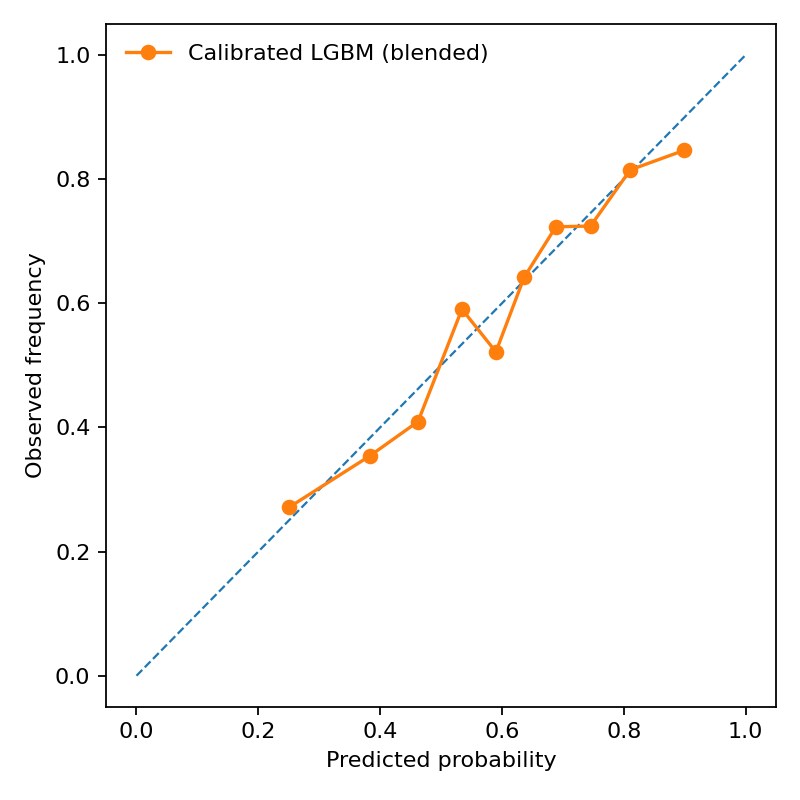

In [ ]:
from IPython.display import Image, display
display(Image(filename="models/reliability.png"))

In [ ]:
import os
os.chdir("/content/drive/MyDrive/nba-prediction")
%env PYTHONPATH=/content/drive/MyDrive/nba-prediction
%env ODDS_CSV=/content/drive/MyDrive/nba-prediction/data/odds.csv

!python scripts/train_full_colab.py

env: PYTHONPATH=/content/drive/MyDrive/nba-prediction
env: ODDS_CSV=/content/drive/MyDrive/nba-prediction/data/odds.csv
[info] Clipped games to <= 2018-06-08 so every test fold has odds.
[info] Odds coverage overall: 90.1%
/content/drive/MyDrive/nba-prediction/scripts/train_full_colab.py:353: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
[Fold 1/3] train=5080 test=846
   cal_size=1016 (with_odds=877) | test_with_odds=705/846
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 2388, number of negative: 1676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds

In [ ]:
import pandas as pd, numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# --- load/normalize games ---
games = pd.read_csv("data/games.csv")
if "GAME_DATE" not in games.columns:
    base_date_col = "GAME_DATE_EST" if "GAME_DATE_EST" in games.columns else None
    assert base_date_col is not None, "Expected GAME_DATE or GAME_DATE_EST in data/games.csv"
    games["GAME_DATE"] = pd.to_datetime(games[base_date_col]).dt.tz_localize(None)
else:
    games["GAME_DATE"] = pd.to_datetime(games["GAME_DATE"]).dt.tz_localize(None)

# keys as string to avoid leading-zero mismatches
games["GAME_ID"] = games["GAME_ID"].astype(str)

# --- load odds (from your converter) ---
odds = pd.read_csv("data/odds.csv")
odds["GAME_DATE"] = pd.to_datetime(odds["GAME_DATE"]).dt.tz_localize(None)
odds["GAME_ID"]   = odds["GAME_ID"].astype(str)

# --- merge using VISITOR_TEAM_ID (games) vs AWAY_TEAM_ID (odds) ---
m = games.merge(
    odds,
    left_on = ["GAME_ID","GAME_DATE","HOME_TEAM_ID","VISITOR_TEAM_ID"],
    right_on= ["GAME_ID","GAME_DATE","HOME_TEAM_ID","AWAY_TEAM_ID"],
    how="left",
)

# --- build target y robustly ---
def first_col(df,*cands):
    for c in cands:
        if c in df.columns: return c
    return None

wins_col = first_col(m, "HOME_TEAM_WINS","home_team_wins","HOME_TEAM_WIN","home_win")
if wins_col:
    y = m[wins_col].astype(int).values
else:
    # derive from points if no explicit wins flag
    h_pts = first_col(m, "PTS_home","HOME_TEAM_SCORE","home_pts","home_score")
    a_pts = first_col(m, "PTS_away","VISITOR_TEAM_SCORE","away_pts","away_score")
    assert h_pts and a_pts, "Could not find points columns to compute the target."
    y = (m[h_pts] > m[a_pts]).astype(int).values

# --- restrict to rows that actually have odds ---
mask = m["fair_home_prob"].notna()
y = y[mask]
p = m.loc[mask, "fair_home_prob"].values

print("Odds coverage over games: {:.1%}".format(mask.mean()))
print("Odds-only AUC:", roc_auc_score(y, p))
print("Odds-only ACC:", accuracy_score(y, (p >= 0.5).astype(int)))

Odds coverage over games: 57.8%
Odds-only AUC: 0.7411471546359524
Odds-only ACC: 0.6881121695961357


In [ ]:
# === DIAGNOSTIC: check odds coverage overall + per fold (self-contained) ===
import pandas as pd, numpy as np

# Keep these three lines in sync with how you train
DATA_GAMES = "/content/drive/MyDrive/nba-prediction/data/games.csv"
ODDS_CSV   = "/content/drive/MyDrive/nba-prediction/data/odds.csv"
N_FOLDS    = 3                # same as your training
DATE_MIN   = "2012-10-01"     # same as your training

# Load games
g = pd.read_csv(DATA_GAMES, low_memory=False)
# Try either GAME_DATE or GAME_DATE_EST depending on your file
date_col = "GAME_DATE" if "GAME_DATE" in g.columns else "GAME_DATE_EST"
g[date_col] = pd.to_datetime(g[date_col], errors="coerce")
g = g.rename(columns={date_col: "GAME_DATE"})
g = g[g["GAME_DATE"] >= pd.to_datetime(DATE_MIN)].reset_index(drop=True)
g["GAME_ID"] = g["GAME_ID"].astype(str)

# Load odds
od = pd.read_csv(ODDS_CSV, low_memory=False)
od_date_col = "GAME_DATE" if "GAME_DATE" in od.columns else ("GAME_DATE_EST" if "GAME_DATE_EST" in od.columns else None)
if od_date_col:
    od[od_date_col] = pd.to_datetime(od[od_date_col], errors="coerce")
od["GAME_ID"] = od["GAME_ID"].astype(str)

# One row per game in odds; keep the latest line per GAME_ID if duplicates exist
if od_date_col:
    od = (od.sort_values(["GAME_ID", od_date_col])
            .drop_duplicates(subset=["GAME_ID"], keep="last"))
else:
    od = od.drop_duplicates(subset=["GAME_ID"], keep="last")

# Must have fair_home_prob in the odds file
assert "fair_home_prob" in od.columns, "Your odds.csv must contain a 'fair_home_prob' column"

# Merge odds onto games by GAME_ID only
g = g.merge(
    od[["GAME_ID","fair_home_prob"]], on="GAME_ID", how="left", validate="m:1"
)

# --- Overall coverage
print("games date range :", g['GAME_DATE'].min(), "→", g['GAME_DATE'].max())
if od_date_col:
    print("odds.csv date range:", od[od_date_col].min(), "→", od[od_date_col].max())
print("overall odds coverage:", f"{g['fair_home_prob'].notna().mean():.1%}")

# Coverage by calendar year
print("\ncoverage by year:")
print(g.assign(has_odds=g["fair_home_prob"].notna())
       .groupby(g["GAME_DATE"].dt.year)["has_odds"].mean().round(3))

# --- Simple walk-forward folds (contiguous time blocks)
g = g.sort_values("GAME_DATE").reset_index(drop=True)
n = len(g)
edges = np.linspace(0, n, N_FOLDS+1, dtype=int)

print("\ncoverage per fold:")
for i in range(N_FOLDS):
    te_start, te_end = edges[i], edges[i+1]
    te_idx = np.arange(te_start, te_end)
    dmin, dmax = g.loc[te_idx, "GAME_DATE"].min(), g.loc[te_idx, "GAME_DATE"].max()
    cov = g.loc[te_idx, "fair_home_prob"].notna().mean()
    print(f"Fold {i+1}: test {dmin.date()} → {dmax.date()}  |  odds_coverage = {cov:.1%}  |  n_test = {len(te_idx)}")

games date range : 2012-10-06 00:00:00 → 2022-03-12 00:00:00
odds.csv date range: 2006-11-01 00:00:00 → 2018-06-08 00:00:00
overall odds coverage: 56.9%

coverage by year:
GAME_DATE
2012    0.790
2013    0.911
2014    0.900
2015    0.901
2016    0.901
2017    0.879
2018    0.556
2019    0.000
2020    0.000
2021    0.000
2022    0.000
Name: has_odds, dtype: float64

coverage per fold:
Fold 1: test 2012-10-06 → 2015-11-09  |  odds_coverage = 88.2%  |  n_test = 4470
Fold 2: test 2015-11-10 → 2018-12-12  |  odds_coverage = 82.4%  |  n_test = 4471
Fold 3: test 2018-12-12 → 2022-03-12  |  odds_coverage = 0.0%  |  n_test = 4471
